In [ ]:
! pip install plotly
! pip install folium
! pip install fuzzywuzzy
! pip install python-Levenshtein
! pip install pycountry-convert
! pip install streamlit-folium



In [53]:
# import pandas for structuring the data
import pandas as pd

# import numpy for numerical analysis
import numpy as np

# import libs for diagrams inline with the text
import matplotlib.pyplot as plt

import seaborn as sns

# other utilities
from sklearn import datasets, preprocessing, metrics

In [54]:
# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as sm

# for diagramming 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

# For serialization and deserialization of data from/to file
import pickle

In [55]:
import folium

In [56]:
# read the json file from your data folder into a data frame
#df = pd.read_csv(r'C:\Users\chz\Documents\BI Exercise\\BI Exam\global air pollution dataset.csv')
df = pd.read_csv(r'C:\Users\chz\Documents\BI Exercise\Datasæt\global_air_pollution_dataset.csv')
df2 = pd.read_csv(r"C:\Users\chz\Documents\BI Exercise\Datasæt\2017_-_Cities_Community_Wide_Emissions.csv")

In [57]:
# Standardizing the 'Country' column in both DataFrames
df['Country'] = df['Country'].str.title().str.strip()
df2['Country'] = df2['Country'].str.title().str.strip()

# Merging df and df2 based on 'Country' after standardization
df_merged = pd.merge(df, df2, on='Country', how='outer')

# Sampling 50 rows from the merged DataFrame to verify the operation
# Note: Since the actual DataFrames are empty in this simulation, this step is for demonstration purposes.
sampled_df_merged = df_merged.sample(50)


In [59]:
df_merged.count()

Country                                         65872
City_x                                          66200
AQI Value                                       66201
AQI Category                                    66201
CO AQI Value                                    66201
CO AQI Category                                 66201
Ozone AQI Value                                 66201
Ozone AQI Category                              66201
NO2 AQI Value                                   66201
NO2 AQI Category                                66201
PM2.5 AQI Value                                 66201
PM2.5 AQI Category                              66201
Account number                                  53096
Organization                                    53096
City_y                                          53096
Region                                          53096
C40                                             14673
Access                                          53096
Reporting year              

In [60]:
df_merged.isnull().sum()

Country                                           427
City_x                                             99
AQI Value                                          98
AQI Category                                       98
CO AQI Value                                       98
CO AQI Category                                    98
Ozone AQI Value                                    98
Ozone AQI Category                                 98
NO2 AQI Value                                      98
NO2 AQI Category                                   98
PM2.5 AQI Value                                    98
PM2.5 AQI Category                                 98
Account number                                  13203
Organization                                    13203
City_y                                          13203
Region                                          13203
C40                                             51626
Access                                          13203
Reporting year              

In [61]:
df_merged.drop(columns=['Gases included'], inplace=True)
df_merged.drop(columns=['Comment'], inplace=True)
df_merged.drop(columns=['Total Scope 1 Emissions (metric tonnes CO2e)'], inplace=True)
df_merged.drop(columns=['Total Scope 2 Emissions (metric tonnes CO2e)'], inplace=True)




In [62]:
# Convert nulls/NaNs to 'False'
df_merged['C40'] = df_merged['C40'].fillna('False')

# Convert any cell that contains "C40" to 'True', assuming "C40" indicates a true condition
# Adjust the condition as needed to match your data's specific representation of true
df_merged['C40'] = df_merged['C40'].apply(lambda x: 'True' if 'C40' in str(x) else 'False')


In [63]:
# Delete the null values from the data frame
df_merged = df_merged.dropna()

In [64]:
# Check the data frame for null values
df_merged.isnull().sum()

Country                                      0
City_x                                       0
AQI Value                                    0
AQI Category                                 0
CO AQI Value                                 0
CO AQI Category                              0
Ozone AQI Value                              0
Ozone AQI Category                           0
NO2 AQI Value                                0
NO2 AQI Category                             0
PM2.5 AQI Value                              0
PM2.5 AQI Category                           0
Account number                               0
Organization                                 0
City_y                                       0
Region                                       0
C40                                          0
Access                                       0
Reporting year                               0
Accounting year                              0
Boundary                                     0
Protocol     

In [65]:
df_merged.count()

Country                                      28833
City_x                                       28833
AQI Value                                    28833
AQI Category                                 28833
CO AQI Value                                 28833
CO AQI Category                              28833
Ozone AQI Value                              28833
Ozone AQI Category                           28833
NO2 AQI Value                                28833
NO2 AQI Category                             28833
PM2.5 AQI Value                              28833
PM2.5 AQI Category                           28833
Account number                               28833
Organization                                 28833
City_y                                       28833
Region                                       28833
C40                                          28833
Access                                       28833
Reporting year                               28833
Accounting year                

In [66]:
df_merged.sample(20)

,Country,City_x,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,...,Population year,GDP,GDP Currency,GDP Year,GDP Source,Average annual temperature (in Celsius)​,​Average altitude (m),​Land area (in square km),City Location,Country Location
50343,Mexico,Mixquiahuala,81.0,Moderate,1.0,Good,24.0,Good,4.0,Good,...,2014.0,2.255223e+12,MXN Mexican Peso,2014.0,INEGI,16.0,2240.0,1485.0,"(19.4326077, -99.133208)","(23.634501, -102.552784)"
22005,Brazil,Pedra Branca,30.0,Good,0.0,Good,14.0,Good,0.0,Good,...,2010.0,8.787850e+09,USD US Dollar,2013.0,IBGE,20.0,3.0,438.0,"(-27.5949884, -48.5481743)","(-14.235004, -51.92528)"
3390,Brazil,Ouro Preto Do Oeste,53.0,Moderate,2.0,Good,0.0,Good,2.0,Good,...,2010.0,7.940000e+10,BRL Brazilian Real,2013.0,http://www.agencia.curitiba.pr.gov.br/publico/...,18.0,935.0,434.0,"(-25.431063, -49.264693)","(-14.235004, -51.92528)"
12434,Brazil,Nilopolis,88.0,Moderate,1.0,Good,35.0,Good,3.0,Good,...,2010.0,7.940000e+10,BRL Brazilian Real,2013.0,http://www.agencia.curitiba.pr.gov.br/publico/...,18.0,935.0,434.0,"(-25.431063, -49.264693)","(-14.235004, -51.92528)"
11379,Brazil,Estrela,14.0,Good,1.0,Good,13.0,Good,0.0,Good,...,2010.0,8.787850e+09,USD US Dollar,2013.0,IBGE,20.0,3.0,438.0,"(-27.5949884, -48.5481743)","(-14.235004, -51.92528)"
52133,Mexico,Huilango,168.0,Unhealthy,4.0,Good,3.0,Good,18.0,Good,...,2014.0,2.255223e+12,MXN Mexican Peso,2014.0,INEGI,16.0,2240.0,1485.0,"(19.4326077, -99.133208)","(23.634501, -102.552784)"
22107,Brazil,Capela Do Alto,72.0,Moderate,2.0,Good,11.0,Good,5.0,Good,...,2016.0,2.998498e+11,BRL Brazilian Real,2014.0,IBGE,23.7,5.0,1224.6,"(-22.9054389, -43.5614471)","(-14.235004, -51.92528)"
58979,Portugal,Leca Do Bailio,28.0,Good,0.0,Good,28.0,Good,2.0,Good,...,2015.0,1.323100e+04,EUR Euro,2013.0,INE(2013) Estudo do poder de compra,17.8,200.0,203.0,"(37.019355, -7.93044)","(39.399872, -8.224454)"
38987,Germany,Konigs Wusterhausen,58.0,Moderate,1.0,Good,29.0,Good,3.0,Good,...,2015.0,1.797500e+04,EUR Euro,2014.0,www.statistik-bw.de,10.9,104.0,145.0,"(49.487459, 8.466039)","(51.165691, 10.451526)"
23494,Italy,Brunico,51.0,Moderate,1.0,Good,47.0,Good,0.0,Good,...,2016.0,1.024555e+10,EUR Euro,2014.0,Data from Unioncamere - Tagliacarne Foundation...,12.0,3.0,414.0,"(45.4332515, 12.3210704)","(41.87194, 12.56738)"


In [67]:
# Extracting latitude and longitude from "City Location" and "Country Location" into new columns
df_merged[['City Latitude', 'City Longitude']] = df_merged['City Location'].str.extract(r'\(([^,]+), ([^)]+)\)')
df_merged[['Country Latitude', 'Country Longitude']] = df_merged['Country Location'].str.extract(r'\(([^,]+), ([^)]+)\)')

# Displaying the first few rows to ensure the transformation was successful
df_merged.head()

,Country,City_x,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,...,GDP Source,Average annual temperature (in Celsius)​,​Average altitude (m),​Land area (in square km),City Location,Country Location,City Latitude,City Longitude,Country Latitude,Country Longitude
1242,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,Ministério da Saúde - DATASUS,23.0,5.0,133.1,"(-22.892857, -43.118381)","(-14.235004, -51.92528)",-22.892857,-43.118381,-14.235004,-51.92528
1243,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,IBGE,20.0,3.0,438.0,"(-27.5949884, -48.5481743)","(-14.235004, -51.92528)",-27.5949884,-48.5481743,-14.235004,-51.92528
1247,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,IBGE,23.7,5.0,1224.6,"(-22.9054389, -43.5614471)","(-14.235004, -51.92528)",-22.9054389,-43.5614471,-14.235004,-51.92528
1248,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,http://www.agencia.curitiba.pr.gov.br/publico/...,18.0,935.0,434.0,"(-25.431063, -49.264693)","(-14.235004, -51.92528)",-25.431063,-49.264693,-14.235004,-51.92528
1249,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,Produto Interno Bruto do Distrito Federal. COD...,21.0,1172.0,5780.0,"(-15.794229, -47.882166)","(-14.235004, -51.92528)",-15.794229,-47.882166,-14.235004,-51.92528


In [68]:
# Convert the latitude and longitude columns from strings to floats
df_merged['City Latitude'] = pd.to_numeric(df_merged['City Latitude'], errors='coerce')
df_merged['City Longitude'] = pd.to_numeric(df_merged['City Longitude'], errors='coerce')
df_merged['Country Latitude'] = pd.to_numeric(df_merged['Country Latitude'], errors='coerce')
df_merged['Country Longitude'] = pd.to_numeric(df_merged['Country Longitude'], errors='coerce')

In [69]:
df_merged.drop(columns=['City Location'], inplace=True)
df_merged.drop(columns=['Country Location'], inplace=True)

In [70]:
# Convert 'C40' from strings "True"/"False" to actual booleans
df_merged['C40'] = df_merged['C40'].map({'True': True, 'False': False})

# Create two new columns: 'C40_True' and 'C40_False'
df_merged['C40_True'] = df_merged['C40'].astype(int)  # This will convert True to 1 and False to 0
df_merged['C40_False'] = (~df_merged['C40']).astype(int)  # This inverts the boolean and then converts to 0/1



In [71]:
df_merged.drop(columns=['C40'], inplace=True)

In [72]:
df = df_merged

In [73]:
df.head()

,Country,City_x,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,...,GDP Source,Average annual temperature (in Celsius)​,​Average altitude (m),​Land area (in square km),City Latitude,City Longitude,Country Latitude,Country Longitude,C40_True,C40_False
1242,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,Ministério da Saúde - DATASUS,23.0,5.0,133.1,-22.892857,-43.118381,-14.235004,-51.92528,0,1
1243,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,IBGE,20.0,3.0,438.0,-27.594988,-48.548174,-14.235004,-51.92528,0,1
1247,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,IBGE,23.7,5.0,1224.6,-22.905439,-43.561447,-14.235004,-51.92528,1,0
1248,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,http://www.agencia.curitiba.pr.gov.br/publico/...,18.0,935.0,434.0,-25.431063,-49.264693,-14.235004,-51.92528,1,0
1249,Brazil,Presidente Dutra,41.0,Good,1.0,Good,5.0,Good,1.0,Good,...,Produto Interno Bruto do Distrito Federal. COD...,21.0,1172.0,5780.0,-15.794229,-47.882166,-14.235004,-51.92528,0,1


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28833 entries, 1242 to 65474
Data columns (total 41 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Country                                    28833 non-null  object 
 1   City_x                                     28833 non-null  object 
 2   AQI Value                                  28833 non-null  float64
 3   AQI Category                               28833 non-null  object 
 4   CO AQI Value                               28833 non-null  float64
 5   CO AQI Category                            28833 non-null  object 
 6   Ozone AQI Value                            28833 non-null  float64
 7   Ozone AQI Category                         28833 non-null  object 
 8   NO2 AQI Value                              28833 non-null  float64
 9   NO2 AQI Category                           28833 non-null  object 
 10  PM2.5 AQI Value         

In [75]:
import pycountry_convert as pc

#applying continent to the dataset for future use of folium mapping
def country_to_continent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
        return country_continent_name
    except:
        return None  # For countries that don't match

# Apply the conversion function to your DataFrame
df['Continent'] = df['Country'].apply(country_to_continent)
# Filter for other continents
north_american_countries_df = df[df['Continent'] == 'North America']
south_american_countries_df = df[df['Continent'] == 'South America']
asian_countries_df = df[df['Continent'] == 'Asia']
african_countries_df = df[df['Continent'] == 'Africa']
oceania_countries_df = df[df['Continent'] == 'Oceania']
Europe_df = df[df['Continent'] == 'Europe']




In [76]:
df.to_pickle("dataframe.pkl") # save df to a pickle file so it can be used for streamlit

In [77]:
df.sample(20)

,Country,City_x,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,...,Average annual temperature (in Celsius)​,​Average altitude (m),​Land area (in square km),City Latitude,City Longitude,Country Latitude,Country Longitude,C40_True,C40_False,Continent
13293,Brazil,Ortigueira,33.0,Good,1.0,Good,12.0,Good,1.0,Good,...,20.8,601.0,450.0,-23.477490,-47.422061,-14.235004,-51.925280,0,1,South America
23952,Italy,Taurianova,57.0,Moderate,1.0,Good,56.0,Moderate,0.0,Good,...,15.0,19.0,240.0,44.347961,9.318415,41.871940,12.567380,0,1,Europe
14621,Brazil,Santo Antonio De Jesus,52.0,Moderate,1.0,Good,7.0,Good,4.0,Good,...,20.0,860.0,346.0,-19.967308,-44.201190,-14.235004,-51.925280,0,1,South America
53319,Japan,Ono,81.0,Moderate,2.0,Good,24.0,Good,12.0,Good,...,16.7,39.0,435.0,35.443708,139.638026,36.204824,138.252924,1,0,Asia
23079,Brazil,Barro,34.0,Good,1.0,Good,8.0,Good,2.0,Good,...,20.8,601.0,450.0,-23.477490,-47.422061,-14.235004,-51.925280,0,1,South America
12143,Brazil,Formoso Do Araguaia,60.0,Moderate,1.0,Good,6.0,Good,2.0,Good,...,20.0,860.0,346.0,-19.967308,-44.201190,-14.235004,-51.925280,0,1,South America
13288,Brazil,Ortigueira,33.0,Good,1.0,Good,12.0,Good,1.0,Good,...,18.0,935.0,434.0,-25.431063,-49.264693,-14.235004,-51.925280,1,0,South America
23613,Italy,Apricena,41.0,Good,2.0,Good,40.0,Good,4.0,Good,...,15.2,50.0,102.4,43.769600,11.255800,41.871940,12.567380,0,1,Europe
53519,Japan,Daigo,56.0,Moderate,1.0,Good,20.0,Good,7.0,Good,...,16.7,39.0,435.0,35.443708,139.638026,36.204824,138.252924,1,0,Asia
24942,Italy,San Ferdinando Di Puglia,40.0,Good,2.0,Good,37.0,Good,6.0,Good,...,15.0,19.0,240.0,44.347961,9.318415,41.871940,12.567380,0,1,Europe


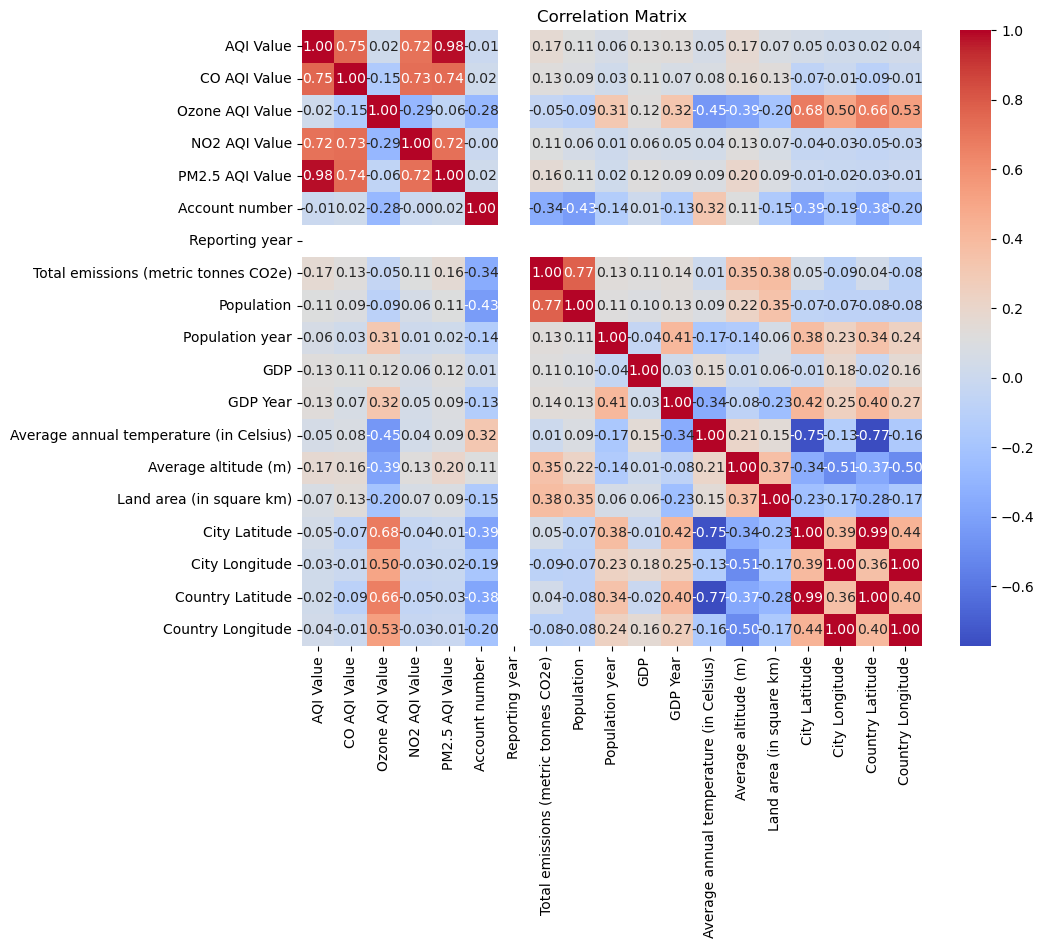

In [78]:
# We have to convert the data from float to int in order to use pandas to calculate the correlations
numeric_df = df.select_dtypes(include=['float64', 'int64'])


df_cleaned = numeric_df.dropna()
# Calculate the correlation matrix
corr_matrix = df_cleaned.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Visualizing relationships between all numerical features
sns.pairplot(df.select_dtypes(include=['float64', 'int64']))
plt.show()


In [ ]:
plt.xlabel('AQI Value')
plt.ylabel('PM2.5 AQI Value')
plt.scatter(df['AQI Value'], df['PM2.5 AQI Value'], color='green')
plt.show()

In [ ]:
sns.distplot(df['AQI Value'],  label='AQI Value', norm_hist=True)  

In [ ]:
sns.distplot(df['PM2.5 AQI Value'],  label='PM2.5 AQI Value', norm_hist=True) 

In [ ]:
# Grouping the data by 'Country' and calculating the mean 'AQI Value' for each country
country_aqi_means = df.groupby('Country')['AQI Value'].mean()

# Sorting the countries by AQI value for better visualization
country_aqi_means = country_aqi_means.sort_values()

# Creating the bar chart
plt.figure(figsize=(15, 25)) 
plt.barh(country_aqi_means.index, country_aqi_means.values, color='skyblue') # Horizontal bar chart
plt.xlabel('Average AQI Value')
plt.ylabel('Country')
plt.title('Average AQI Value by Country')
plt.tight_layout() # Adjusts subplot params so that the subplot(s) fits in to the figure area.

plt.show()

In [ ]:
# Grouping the data by 'Country' and calculating the mean 'PM2.5 AQI Value' for each country
country_pm25_means = df.groupby('Country')['PM2.5 AQI Value'].mean()
# Sorting the countries by PM2.5 AQI value for better visualization
country_pm25_means = country_pm25_means.sort_values()
# Creating the bar chart
plt.figure(figsize=(15, 25))
plt.barh(country_pm25_means.index, country_pm25_means.values, color='skyblue') # Horizontal bar chart
plt.xlabel('Average PM2.5 AQI Value')
plt.ylabel('Country')
plt.title('Average PM2.5 AQI Value by Country')
plt.tight_layout() # Adjusts subplot params so that the subplot(s) fits in to the figure area.
plt.show()


In [ ]:
X = df['AQI Value'].values.reshape(-1, 1)
y = df['PM2.5 AQI Value'].values.reshape(-1, 1)

In [ ]:
# plot all
plt.ylabel('PM2.5 AQI Value')
plt.xlabel('AQI Value')
plt.scatter(X, y, color='blue')
plt.show()

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.15) 

In [ ]:
# the shape of the subsets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
# creating an instance of Linear Regression model
myreg = LinearRegression()

In [ ]:
# fit it to our data
myreg.fit(X_train, y_train)
myreg

In [ ]:
# get the calculated coefficients
a = myreg.coef_
b = myreg.intercept_

In [ ]:
a

In [ ]:
b

In [ ]:
y_predicted = myreg.predict(X_test)
y_predicted

In [ ]:
y_test

In [ ]:
# Visualise the Linear Regression 
plt.title('Linear Regression')
plt.scatter(X, y, color='green')
plt.plot(X_train, a*X_train + b, color='blue')
plt.plot(X_test, y_predicted, color='orange')
plt.xlabel('length')
plt.ylabel('age')
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Predicting on the test set
y_pred = myreg.predict(X_test)

# Calculating metrics
print("R^2: ", r2_score(y_test, y_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))

In [ ]:
#create a scatter plot of the 'AQI Value' and 'PM2.5 AQI Value' columns and color the points by the 'Country' column
fig = px.scatter(df, x='AQI Value', y='PM2.5 AQI Value', color='Country', title='AQI Value vs PM2.5 AQI Value')
fig.show()


In [ ]:
# divide the data into 5 clusters using the KMeans algorithm
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(df[['AQI Value', 'PM2.5 AQI Value']])
df['cluster'] = kmeans.predict(df[['AQI Value', 'PM2.5 AQI Value']])
df.sample(10)



In [ ]:
# create a scatter plot of the 'AQI Value' and 'PM2.5 AQI Value' columns and color the points by the 'cluster' column
fig = px.scatter(df, x='AQI Value', y='PM2.5 AQI Value', color='cluster', title='AQI Value vs PM2.5 AQI Value')
fig.show()


In [ ]:
# Fit the model and predict clusters
kmeans = KMeans(n_clusters=5, random_state=42).fit(df_filtered[['AQI Value', 'PM2.5 AQI Value']])
df_filtered['cluster'] = kmeans.labels_

# Analyze centroids
centroids = kmeans.cluster_centers_
print("Centroids:\n", centroids)

# Plotting clusters and centroids
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_filtered, x='AQI Value', y='PM2.5 AQI Value', hue='cluster', palette='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red', label='Centroids')
plt.legend()
plt.show()


In [ ]:
population_data = df[['Country', 'Population']]

# Grouping and aggregating population data by country
population_by_country = population_data.groupby('Country')['Population'].sum().reset_index()

# Creating a pivot table with 'Country' as index
pivot_population = population_by_country.set_index('Country')

# Creating the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=pivot_population, cmap='YlGnBu', annot=True, fmt=',.0f', linewidths=.5)
plt.title('Population by Country')
plt.xlabel('population')
plt.ylabel('Country')
plt.show()

In [ ]:
# Splitting the 'Country Location' column into separate longitude and latitude columns
df[['Latitude', 'Longitude']] = df['Country Location'].str.strip('()').str.split(', ', expand=True).astype(float)

# Creating a 3D scatter plot
scatter_plot = go.Scatter3d(
    x=df['Longitude'],
    y=df['Latitude'],
    z=df['Population year'],
    mode='markers',
    marker=dict(
        size=5,
        color='blue',                # Set color to an array/list of desired values
        opacity=0.8
    )
)

# Setting layout
layout = go.Layout(
    title='3D Population Map',
    scene=dict(
        xaxis=dict(title='Country Longitude'),
        yaxis=dict(title='Country Latitude'),
        zaxis=dict(title='Population')
    )
)

# Combining data and layout into a figure
fig = go.Figure(data=[scatter_plot], layout=layout)

# Show the figure
fig.show()

In [79]:
df_europe = df[df['Continent'] == 'Europe']

In [91]:
df_europe.sample(50)

,Country,City_x,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,...,Average annual temperature (in Celsius)​,​Average altitude (m),​Land area (in square km),City Latitude,City Longitude,Country Latitude,Country Longitude,C40_True,C40_False,Continent
28671,Italy,Nonantola,57.0,Moderate,1.0,Good,24.0,Good,10.0,Good,...,15.2,50.0,102.4,43.769600,11.255800,41.871940,12.567380,0,1,Europe
59363,Portugal,Pedroso,35.0,Good,1.0,Good,35.0,Good,2.0,Good,...,15.0,348.0,241.0,41.444266,-8.292241,39.399872,-8.224454,0,1,Europe
29186,Poland,Chorzow,111.0,Unhealthy for Sensitive Groups,2.0,Good,25.0,Good,10.0,Good,...,8.0,103.0,517.0,52.229676,21.012229,51.919438,19.145136,1,0,Europe
61842,Spain,Arahal,43.0,Good,1.0,Good,43.0,Good,0.0,Good,...,16.3,208.0,978.0,41.608629,-0.887012,40.463667,-3.749220,0,1,Europe
39050,Germany,Sendenhorst,35.0,Good,1.0,Good,33.0,Good,2.0,Good,...,13.2,114.0,109.0,49.398752,8.672434,51.165691,10.451526,1,0,Europe
29913,France,Rombas,24.0,Good,1.0,Good,23.0,Good,3.0,Good,...,13.5,26.0,105.0,48.856614,2.352222,46.227638,2.213749,1,0,Europe
59003,Portugal,Grandola,37.0,Good,0.0,Good,28.0,Good,1.0,Good,...,15.0,348.0,241.0,41.444266,-8.292241,39.399872,-8.224454,0,1,Europe
29280,Poland,Opoczno,73.0,Moderate,1.0,Good,31.0,Good,2.0,Good,...,8.0,103.0,517.0,52.229676,21.012229,51.919438,19.145136,1,0,Europe
36730,Germany,Rastatt,44.0,Good,1.0,Good,35.0,Good,4.0,Good,...,13.2,114.0,109.0,49.398752,8.672434,51.165691,10.451526,1,0,Europe
41440,Netherlands,Boxtel,30.0,Good,0.0,Good,30.0,Good,2.0,Good,...,10.9,2.0,219.0,52.370216,4.895168,52.132633,5.291266,1,0,Europe


In [97]:
df_sampled = df_europe.sample(n=500, replace=False, random_state=42) 

In [98]:
df_sampled.count()

Country                                      500
City_x                                       500
AQI Value                                    500
AQI Category                                 500
CO AQI Value                                 500
CO AQI Category                              500
Ozone AQI Value                              500
Ozone AQI Category                           500
NO2 AQI Value                                500
NO2 AQI Category                             500
PM2.5 AQI Value                              500
PM2.5 AQI Category                           500
Account number                               500
Organization                                 500
City_y                                       500
Region                                       500
Access                                       500
Reporting year                               500
Accounting year                              500
Boundary                                     500
Protocol            

In [102]:
import folium
import json

# Load the GeoJSON data from a local file
with open(r"C:\Users\chz\Documents\BI Exercise\Datasæt\Eumap.json", 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Assuming 'df' is your DataFrame and already correctly set up
m = folium.Map(location=[df_sampled['Country Latitude'].mean(), df_sampled['Country Longitude'].mean()], zoom_start=3)

# Add markers for each data point
for index, row in df.iterrows():
    folium.Marker([row['Country Latitude'], row['Country Longitude']], popup=row['Population']).add_to(m)

# Add polygon overlays for countries using the loaded GeoJSON data
folium.GeoJson(data=geojson_data).add_to(m)

# Save and display the map
m.save('map.html')


In [ ]:
m